In [1]:
import pandas as pd
from pyinaturalist import *
import inspect
#from pyinaturalist_convert import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import datetime
from dateutil.tz import tzutc, tzoffset
import geopandas as gpd
from tqdm.notebook import tqdm
tqdm.pandas()

/var/folders/07/cyf36j6s41qc8nccrvkfbly40000gn/T/ipykernel_52216/4038813943.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/kommunizm/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# import nztcs_export.xlsx
nz_stats = pd.read_excel('nztcs_export.xlsx')

/Users/kommunizm/Library/Python/3.9/lib/python/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
# print all unique values of Stauts
print(nz_stats['Status'].unique())

['Data Deficient' 'Not Threatened' 'Relict' 'Declining'
 'Naturally Uncommon' 'Nationally Vulnerable' 'Nationally Endangered'
 'Nationally Critical' 'Introduced and Naturalised' 'Recovering' 'Vagrant'
 'Extinct' 'Not assessed' 'Nationally Increasing' 'Coloniser'
 'Taxonomically indistinct' 'Migrant' 'Sparse' 'Gradual Decline'
 'Not listed' 'Serious Decline' 'Range Restricted']


In [4]:
# import inat_nz.csv
inat_nz = pd.read_csv('inat_nz.csv', delimiter='\t', encoding='utf-8')
print(inat_nz)

             gbifID                            datasetKey  \
0        1990598370  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1        2237479673  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2        2269256337  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3        2269289954  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4        2422945129  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
...             ...                                   ...   
1266927  2236867469  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1266928  2239041061  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1266929  2251897164  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1266930  2422962432  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1266931  2445162324  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

                                              occurrenceID   kingdom  \
0        https://www.inaturalist.org/observations/19900806   Plantae   
1        https://www.inaturalist.org/observations/22863983     Fungi   
2        https://www.inaturalist.org/observations/2

In [5]:
# Get the counts of each scientific name
species_counts = inat_nz['scientificName'].value_counts()

# Reset index to convert the series to a DataFrame
species_counts = species_counts.reset_index()

# Rename columns to appropriate names
species_counts.columns = ['scientificName', 'count']

# Add the 'class' column
species_counts['class'] = inat_nz.groupby('scientificName')['class'].first().values

species_counts['kingdom'] = inat_nz.groupby('scientificName')['kingdom'].first().values
species_counts['order'] = inat_nz.groupby('scientificName')['order'].first().values

# Add the 'phylum' column
species_counts['phylum'] = inat_nz.groupby('scientificName')['phylum'].first().values

# Get only the first two words of the scientific name
species_counts['scientificName'] = species_counts['scientificName'].str.split().str[:2].str.join(' ')

# Drop duplicates
species_counts = species_counts.drop_duplicates()
species_counts['class'].fillna('Actinopterygii', inplace=True)
species_counts.loc[species_counts['class'] == 'Squamata', 'order'] = 'Squamata'
# Reset index
species_counts = species_counts.reset_index(drop=True)

# Display the tail of the DataFrame
print(species_counts.tail())


             scientificName  count            class  kingdom  \
15703               Anu una      1        Bryopsida  Plantae   
15704  Epichloe coenophiala      1  Sordariomycetes    Fungi   
15705   Inocybe horakomyces      1  Sordariomycetes    Fungi   
15706      Rhodocybe gemina      1  Dothideomycetes    Fungi   
15707      Erysiphe azaleae      1    Magnoliopsida  Plantae   

                   order        phylum  
15703     Orthotrichales     Bryophyta  
15704         Xylariales    Ascomycota  
15705         Xylariales    Ascomycota  
15706  Mycosphaerellales    Ascomycota  
15707       Saxifragales  Tracheophyta  


/var/folders/07/cyf36j6s41qc8nccrvkfbly40000gn/T/ipykernel_52216/778967618.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  species_counts['class'].fillna('Actinopterygii', inplace=True)


In [6]:
# define the lambda apply_progress function separately to handle exceptions
def find_match(x):
    try:
        return nz_stats[nz_stats['Current Species Name'].str.contains(x, case=False)]['Status'].values[0]
    except:
        return ''

In [7]:
# apply the function to the column
species_counts['status'] = species_counts['scientificName'].progress_apply(find_match)
print(species_counts)

  0%|          | 0/15708 [00:00<?, ?it/s]

/var/folders/07/cyf36j6s41qc8nccrvkfbly40000gn/T/ipykernel_52216/3988510288.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return nz_stats[nz_stats['Current Species Name'].str.contains(x, case=False)]['Status'].values[0]


                        scientificName  count            class   kingdom  \
0            Hemiphaga novaeseelandiae   9629     Demospongiae  Animalia   
1                  Cordyline australis   4767     Demospongiae  Animalia   
2        Prosthemadera novaeseelandiae   4331     Demospongiae  Animalia   
3      Chroicocephalus novaehollandiae   4226    Magnoliopsida   Plantae   
4                  Ichneutica Meyrick,   4093          Insecta  Animalia   
...                                ...    ...              ...       ...   
15703                          Anu una      1        Bryopsida   Plantae   
15704             Epichloe coenophiala      1  Sordariomycetes     Fungi   
15705              Inocybe horakomyces      1  Sordariomycetes     Fungi   
15706                 Rhodocybe gemina      1  Dothideomycetes     Fungi   
15707                 Erysiphe azaleae      1    Magnoliopsida   Plantae   

                   order        phylum          status  
0             Suberitida      

In [8]:
# Replace empty strings with 'Unknown' in the 'status' column
species_counts['status'] = species_counts['status'].replace('', 'Unknown')

# Pivot the dataframe
pivot_table = species_counts.pivot_table(index=['class', 'status', 'phylum', 'kingdom','order'], values='scientificName', aggfunc='nunique').reset_index()
# Import pandas library if not already imported


# Rename the 'scientificName' column to 'count'
pivot_table.rename(columns={'scientificName': 'count'}, inplace=True)

# Display the DataFrame
print(pivot_table)

# Filter the DataFrame
filtered_pivot_table = pivot_table[pivot_table['kingdom'] == 'Animalia']

filtered_species_counts = filtered_pivot_table 
# Display the filtered DataFrame
print(filtered_species_counts)


                 class              status            phylum   kingdom  \
0        Actinomycetia             Unknown  Actinobacteriota  Bacteria   
1        Actinomycetia             Unknown  Actinobacteriota  Bacteria   
2       Actinopterygii           Coloniser          Chordata  Animalia   
3       Actinopterygii      Data Deficient          Chordata  Animalia   
4       Actinopterygii      Data Deficient          Chordata  Animalia   
...                ...                 ...               ...       ...   
1706    Zoopagomycetes  Naturally Uncommon     Zoopagomycota     Fungi   
1707    Zoopagomycetes             Unknown     Zoopagomycota     Fungi   
1708  Zygnematophyceae  Naturally Uncommon        Charophyta   Plantae   
1709  Zygnematophyceae      Not Threatened        Charophyta   Plantae   
1710  Zygnematophyceae             Unknown        Charophyta   Plantae   

                 order  count  
0      Actinomycetales      3  
1     Streptomycetales      3  
2          Perc

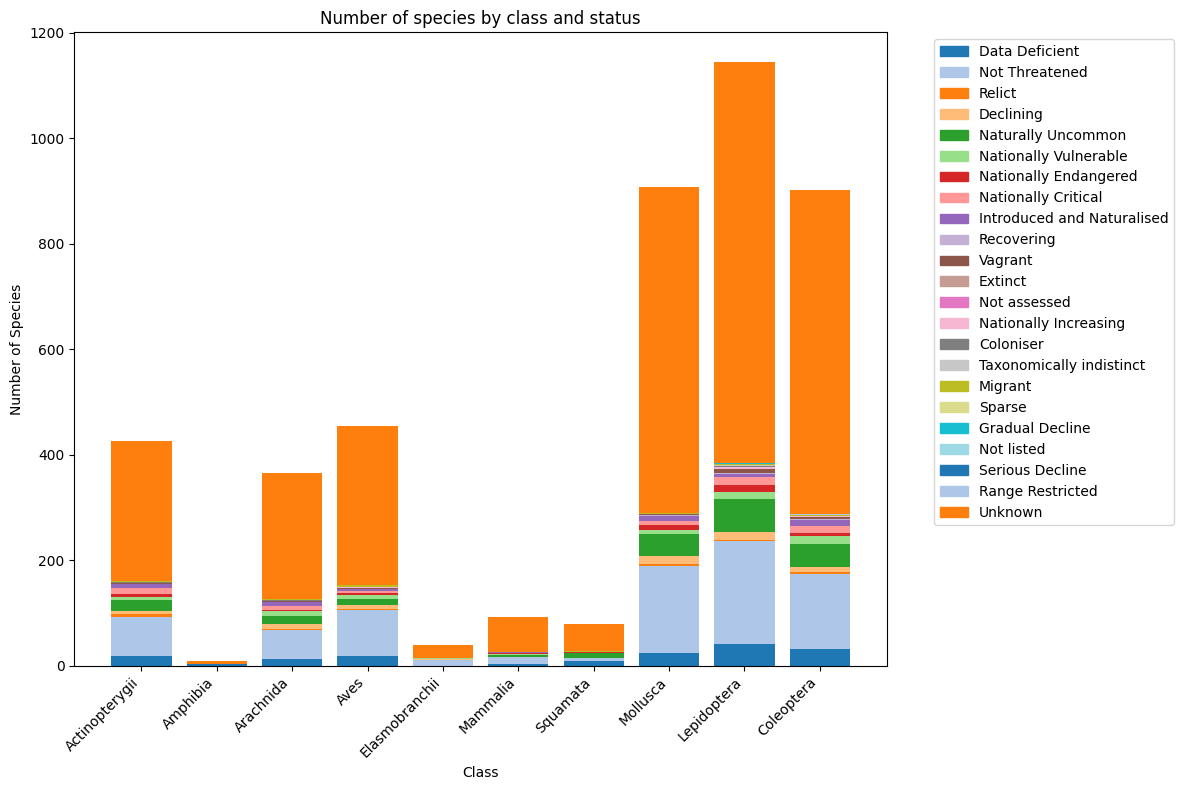

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define the unique status values including "Unknown"
status_values = ['Data Deficient', 'Not Threatened', 'Relict', 'Declining', 'Naturally Uncommon', 
                 'Nationally Vulnerable', 'Nationally Endangered', 'Nationally Critical', 
                 'Introduced and Naturalised', 'Recovering', 'Vagrant', 'Extinct', 'Not assessed', 
                 'Nationally Increasing', 'Coloniser', 'Taxonomically indistinct', 'Migrant', 
                 'Sparse', 'Gradual Decline', 'Not listed', 'Serious Decline', 'Range Restricted', 'Unknown']

# Create a color palette for the statuses
colors = sns.color_palette("tab20", len(status_values))

# Map each status to a color
status_color_map = {status: colors[i] for i, status in enumerate(status_values)}

# Filter data for the specified classes
filtered_classes = filtered_species_counts[filtered_species_counts['class'].isin(['Aves', 'Arachnida', 'Actinopterygii', 
                                                    'Mammalia', 'Amphibia', 'Squamata', 'Elasmobranchii'])]

# Filter data for kingdom = Animalia and phylum = Mollusca
mollusca_data = filtered_species_counts[(filtered_species_counts['kingdom'] == 'Animalia') & 
                                        (filtered_species_counts['phylum'] == 'Mollusca')]

insecta_data_l = filtered_species_counts[
                                        (filtered_species_counts['order'].isin(['Lepidoptera']))]
insecta_data_c = filtered_species_counts[
                                        (filtered_species_counts['order'].isin(['Coleoptera']))]


# Concatenate mollusca_df with filtered_classes DataFrame
new_filtered_classes = pd.concat([filtered_classes])

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over each class
for i, class_name in enumerate(new_filtered_classes['class'].unique()):
    class_data = new_filtered_classes[new_filtered_classes['class'] == class_name]
    class_data = class_data.reset_index(drop=True)
    
    class_status_counts = class_data.groupby('status')['count'].sum()
    
    # Plot the bar chart for each status within the class
    bottom = 0
    for j, status in enumerate(status_values):
        count = class_status_counts.get(status, 0)
        ax.bar(i, count, bottom=bottom, color=status_color_map.get(status, (0.5, 0.5, 0.5)), label=status)
        bottom += count

# Plot the bar chart for Mollusca with status data
class_data = mollusca_data
class_data = class_data.reset_index(drop=True)
class_status_counts = class_data.groupby('status')['count'].sum()


# Plot the bar chart for each status within Mollusca
bottom = 0
i += 1  # Increment i to plot Mollusca data in a separate bar
for j, status in enumerate(status_values):
    count = class_status_counts.get(status, 0)
    ax.bar(i, count, bottom=bottom, color=status_color_map.get(status, (0.5, 0.5, 0.5)), label=status)
    bottom += count

# Plot the bar chart for insecta with status data
class_data = insecta_data_l
class_data = class_data.reset_index(drop=True)
class_status_counts = class_data.groupby('status')['count'].sum()



# Plot the bar chart for each status within Mollusca
bottom = 0
i += 1  # Increment i to plot Insecta data in a separate bar
for j, status in enumerate(status_values):
    count = class_status_counts.get(status, 0)
    ax.bar(i, count, bottom=bottom, color=status_color_map.get(status, (0.5, 0.5, 0.5)), label=status)
    bottom += count

# Plot the bar chart for insecta with status data
class_data = insecta_data_c
class_data = class_data.reset_index(drop=True)
class_status_counts = class_data.groupby('status')['count'].sum()


# Plot the bar chart for each status within Mollusca
bottom = 0
i += 1  # Increment i to plot Insecta data in a separate bar
for j, status in enumerate(status_values):
    count = class_status_counts.get(status, 0)
    ax.bar(i, count, bottom=bottom, color=status_color_map.get(status, (0.5, 0.5, 0.5)), label=status)
    bottom += count

# Set x-axis ticks and labels
ax.set_xticks(range(len(new_filtered_classes['class'].unique()) + 3))
ax.set_xticklabels(list(new_filtered_classes['class'].unique()) + ['Mollusca'] + ['Lepidoptera'] + ['Coleoptera'], rotation=45, ha='right')

# Customize plot
ax.set_title('Number of species by class and status')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Species')

# Create custom legend patches
legend_patches = [Patch(color=status_color_map[status], label=status) for status in status_values]

# Display legend with custom patches
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [10]:
# Get the counts of each scientific name
species_counts = nz_stats['Current Species Name'].value_counts()

# Reset index to convert the series to a DataFrame
species_counts = species_counts.reset_index()

# Rename columns to appropriate names
species_counts.columns = ['Current Species Name', 'count']

# Add the 'class' column
species_counts['Class'] = nz_stats.groupby('Current Species Name')['Class'].first().values

species_counts['Kingdom'] = nz_stats.groupby('Current Species Name')['Kingdom'].first().values
species_counts['Order'] = nz_stats.groupby('Current Species Name')['Order'].first().values
# Add the 'phylum' column
species_counts['Phylum'] = nz_stats.groupby('Current Species Name')['Phylum'].first().values
species_counts['Status'] = nz_stats.groupby('Current Species Name')['Status'].first().values

# Get only the first two words of the scientific name
species_counts['Current Species Name'] = species_counts['Current Species Name'].str.split().str[:2].str.join(' ')

# Drop duplicates
species_counts = species_counts.drop_duplicates()
species_counts['Class'].fillna('Actinopterygii', inplace=True)
# Reset index
species_counts = species_counts.reset_index(drop=True)

# Display the tail of the DataFrame
print(species_counts.tail())

# Replace empty strings with 'Unknown' in the 'status' column
species_counts['Status'] = species_counts['Status'].replace('', 'Unknown')

# Pivot the dataframe
pivot_table = species_counts.pivot_table(index=['Class', 'Status', 'Phylum', 'Kingdom','Order'], values='Current Species Name', aggfunc='nunique').reset_index()
# Import pandas library if not already imported


# Rename the 'scientificName' column to 'count'
pivot_table.rename(columns={'Current Species Name': 'count'}, inplace=True)

# Display the DataFrame
print(pivot_table)

# Filter the DataFrame
filtered_pivot_table = pivot_table[pivot_table['Kingdom'] == 'Animalia']

filtered_species_counts = filtered_pivot_table 
# Display the filtered DataFrame
print(filtered_species_counts)

      Current Species Name  count                      Class   Kingdom  \
15003   Gasparia mangamuka      1                  Arachnida  Animalia   
15004  Gasparia manneringi      1                 Gastropoda  Animalia   
15005     Gasparia montana      1                  Bryopsida   Plantae   
15006        Gasparia nava      1  Ascomycota incertae sedis     Fungi   
15007     Zachvatkinia sp.      1                Secernentea  Animalia   

                                 Order      Phylum                      Status  
15003                          Araneae  Arthropoda  Introduced and Naturalised  
15004                  Neotaenioglossa    Mollusca          Naturally Uncommon  
15005                   Orthotrichales   Bryophyta          Naturally Uncommon  
15006  Ascomycota Order incertae sedis  Ascomycota              Data Deficient  
15007                       Tylenchida    Nematoda              Not Threatened  
                  Class          Status         Phylum    Kingdom  \


/var/folders/07/cyf36j6s41qc8nccrvkfbly40000gn/T/ipykernel_52216/514638816.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  species_counts['Class'].fillna('Actinopterygii', inplace=True)


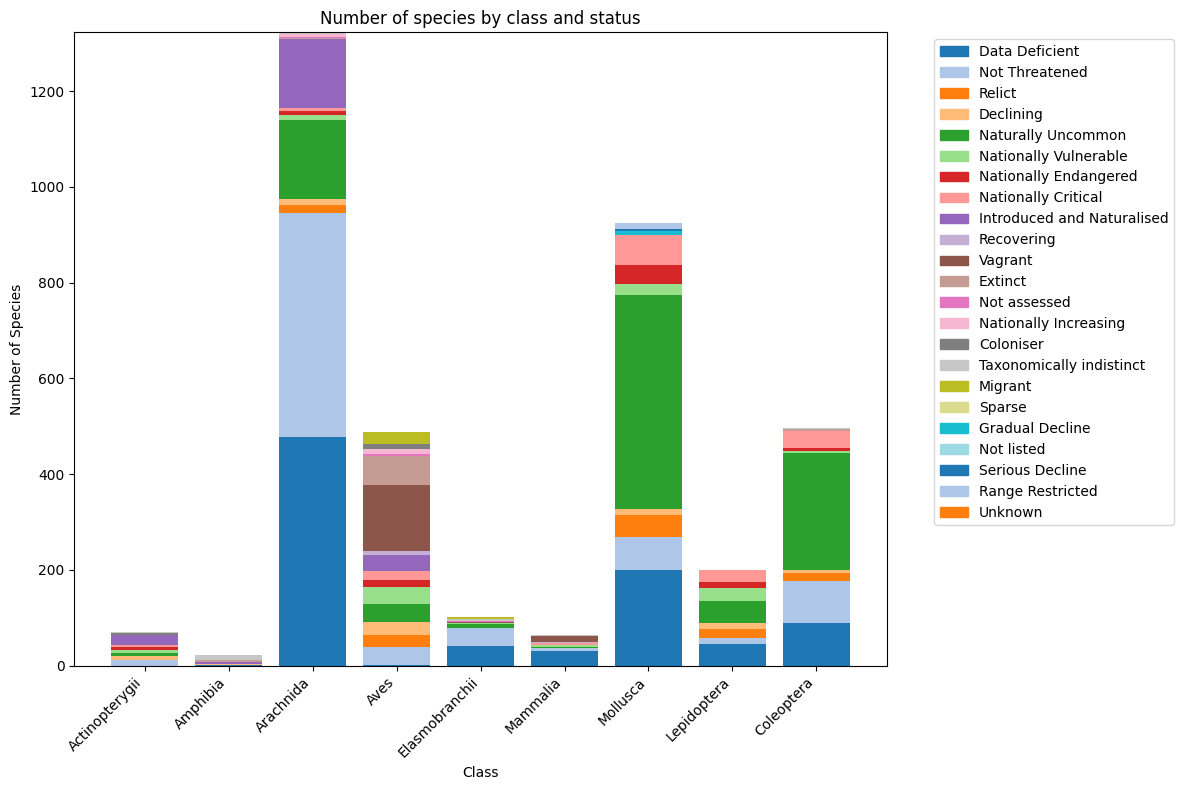

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define the unique status values including "Unknown"
status_values = ['Data Deficient', 'Not Threatened', 'Relict', 'Declining', 'Naturally Uncommon', 
                 'Nationally Vulnerable', 'Nationally Endangered', 'Nationally Critical', 
                 'Introduced and Naturalised', 'Recovering', 'Vagrant', 'Extinct', 'Not assessed', 
                 'Nationally Increasing', 'Coloniser', 'Taxonomically indistinct', 'Migrant', 
                 'Sparse', 'Gradual Decline', 'Not listed', 'Serious Decline', 'Range Restricted', 'Unknown']

# Create a color palette for the statuses
colors = sns.color_palette("tab20", len(status_values))


# Map each status to a color
status_color_map = {status: colors[i] for i, status in enumerate(status_values)}

# Filter data for the specified classes
filtered_classes = filtered_species_counts[filtered_species_counts['Class'].isin(['Aves', 'Arachnida', 'Actinopterygii', 
                                                    'Mammalia', 'Amphibia', 'Squamata', 'Elasmobranchii'])]

# Filter data for kingdom = Animalia and phylum = Mollusca
mollusca_data = filtered_species_counts[(filtered_species_counts['Kingdom'] == 'Animalia') & 
                                        (filtered_species_counts['Phylum'] == 'Mollusca')]

insecta_data_l = filtered_species_counts[
                                        (filtered_species_counts['Order'].isin(['Lepidoptera']))]
insecta_data_c = filtered_species_counts[
                                        (filtered_species_counts['Order'].isin(['Coleoptera']))]


# Concatenate mollusca_df with filtered_classes DataFrame
new_filtered_classes = pd.concat([filtered_classes])

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over each class
for i, class_name in enumerate(new_filtered_classes['Class'].unique()):
    class_data = new_filtered_classes[new_filtered_classes['Class'] == class_name]
    class_data = class_data.reset_index(drop=True)
    
    class_status_counts = class_data.groupby('Status')['count'].sum()
    
    # Plot the bar chart for each status within the class
    bottom = 0
    for j, status in enumerate(status_values):
        count = class_status_counts.get(status, 0)
        ax.bar(i, count, bottom=bottom, color=status_color_map.get(status, (0.5, 0.5, 0.5)), label=status)
        bottom += count

# Plot the bar chart for Mollusca with status data
class_data = mollusca_data
class_data = class_data.reset_index(drop=True)
class_status_counts = class_data.groupby('Status')['count'].sum()


# Plot the bar chart for each status within Mollusca
bottom = 0
i += 1  # Increment i to plot Mollusca data in a separate bar
for j, status in enumerate(status_values):
    count = class_status_counts.get(status, 0)
    ax.bar(i, count, bottom=bottom, color=status_color_map.get(status, (0.5, 0.5, 0.5)), label=status)
    bottom += count

# Plot the bar chart for insecta with status data
class_data = insecta_data_l
class_data = class_data.reset_index(drop=True)
class_status_counts = class_data.groupby('Status')['count'].sum()



# Plot the bar chart for each status within Mollusca
bottom = 0
i += 1  # Increment i to plot Insecta data in a separate bar
for j, status in enumerate(status_values):
    count = class_status_counts.get(status, 0)
    ax.bar(i, count, bottom=bottom, color=status_color_map.get(status, (0.5, 0.5, 0.5)), label=status)
    bottom += count

# Plot the bar chart for insecta with status data
class_data = insecta_data_c
class_data = class_data.reset_index(drop=True)
class_status_counts = class_data.groupby('Status')['count'].sum()


# Plot the bar chart for each status within Mollusca
bottom = 0
i += 1  # Increment i to plot Insecta data in a separate bar
for j, status in enumerate(status_values):
    count = class_status_counts.get(status, 0)
    ax.bar(i, count, bottom=bottom, color=status_color_map.get(status, (0.5, 0.5, 0.5)), label=status)
    bottom += count

# Set x-axis ticks and labels
ax.set_xticks(range(len(new_filtered_classes['Class'].unique()) + 3))
ax.set_xticklabels(list(new_filtered_classes['Class'].unique()) + ['Mollusca'] + ['Lepidoptera'] + ['Coleoptera'], rotation=45, ha='right')

# Customize plot
ax.set_title('Number of species by class and status')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Species')

# Create custom legend patches
legend_patches = [Patch(color=status_color_map[status], label=status) for status in status_values]

# Display legend with custom patches
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
